# Load Data

In [1]:
# download spellchecker
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.4 MB/s eta 0:00:0000:0100:01


In [2]:
#@title import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from spellchecker import SpellChecker
import spacy
from spacy.language import Language
from spacy import displacy
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.model_selection import *
from sklearn.naive_bayes import  MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

In [3]:
#@title read data
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
#@title sample of data
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#@title data column
print(f'Train : {train_data.columns} \n\nTest : {test_data.columns}')

Train : Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object') 

Test : Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [6]:
#@title data info
print('Train\n')
print(train_data.info())
print('\n\nTest\n')
print(test_data.info())

Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


Test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [7]:
#@title data shape
print(f'Train = {train_data.shape}\n\nTest = {test_data.shape}')

Train = (7613, 5)

Test = (3263, 4)


In [8]:
#@title target data
t_data = dict(train_data['target'].value_counts())
t_data

{0: 4342, 1: 3271}

In [9]:
#@title actual labels
labels = ['not disaster','disaster']

In [10]:
#@title adjust language
nlp = spacy.load('en_core_web_sm')

# EDA

<Axes: title={'center': 'Count target'}>

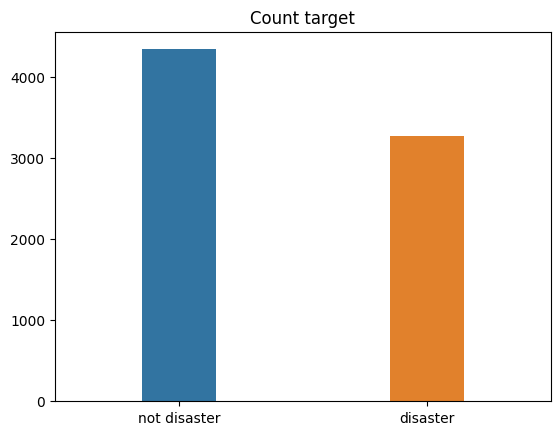

In [11]:
#@title target visualization
plt.title('Count target')
sns.barplot(x = labels , y = list(t_data.values()) ,width = 0.3)

<Axes: title={'center': 'Document length'}>

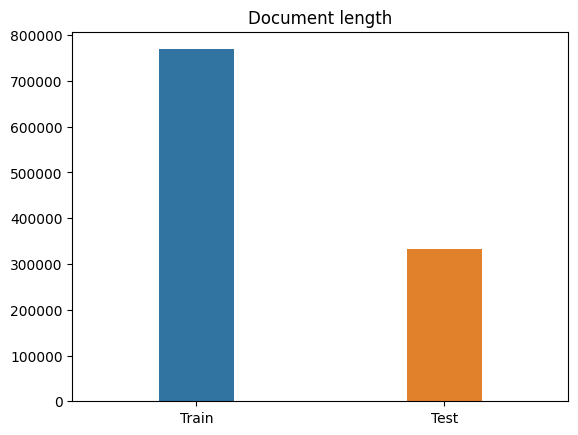

In [12]:
#@title doc length
train_data['doc_len'] = train_data['text'].apply(lambda x : len(x))
test_data['doc_len'] = test_data['text'].apply(lambda x : len(x))
plt.title('Document length' )
sns.barplot(x = ['Train' , 'Test'] , y = [train_data['doc_len'].sum(), test_data['doc_len'].sum()], width = 0.3)

/tmp/ipykernel_32/1308348702.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


<Axes: title={'center': 'Test location'}>

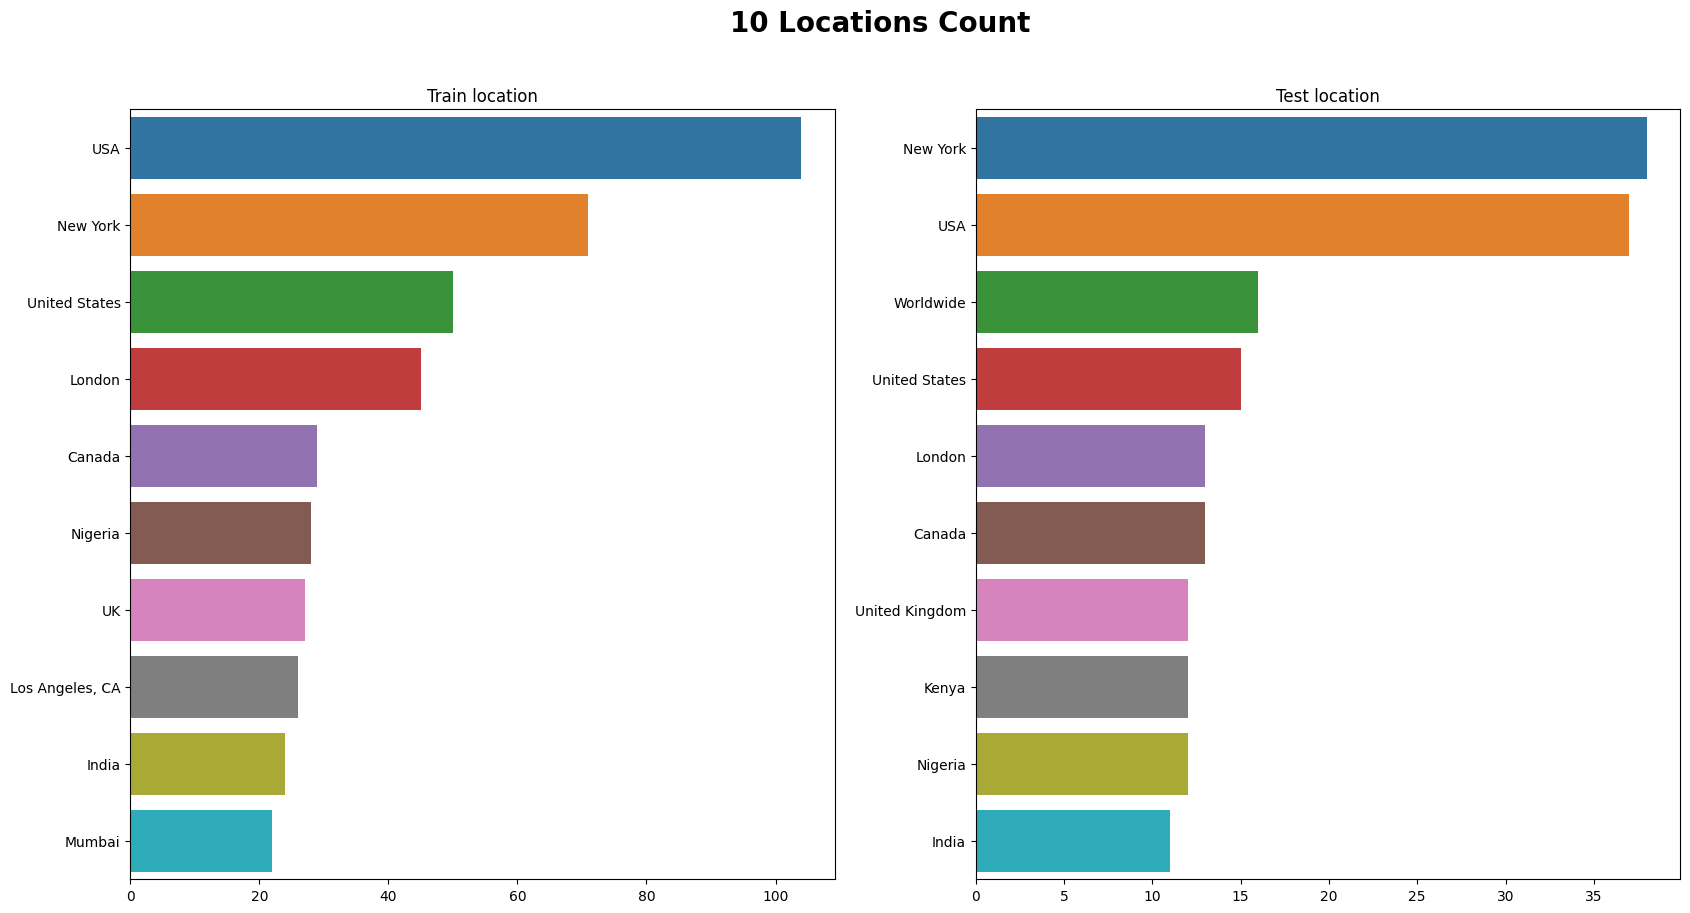

In [13]:
#@title different locations
train_loc = dict(train_data['location'].value_counts())
test_loc = dict(test_data['location'].value_counts())
fig,axs  = plt.subplots(figsize  = (20,10))
fig.suptitle('10 Locations Count', ha='center', fontweight='bold', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Train location')
sns.barplot(y=list(train_loc.keys())[:10], x=list(train_loc.values())[:10])

plt.subplot(1, 2, 2)
plt.title('Test location')
sns.barplot(y=list(test_loc.keys())[:10], x=list(test_loc.values())[:10])

/tmp/ipykernel_32/1320683439.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


<Axes: title={'center': 'Test keyword'}>

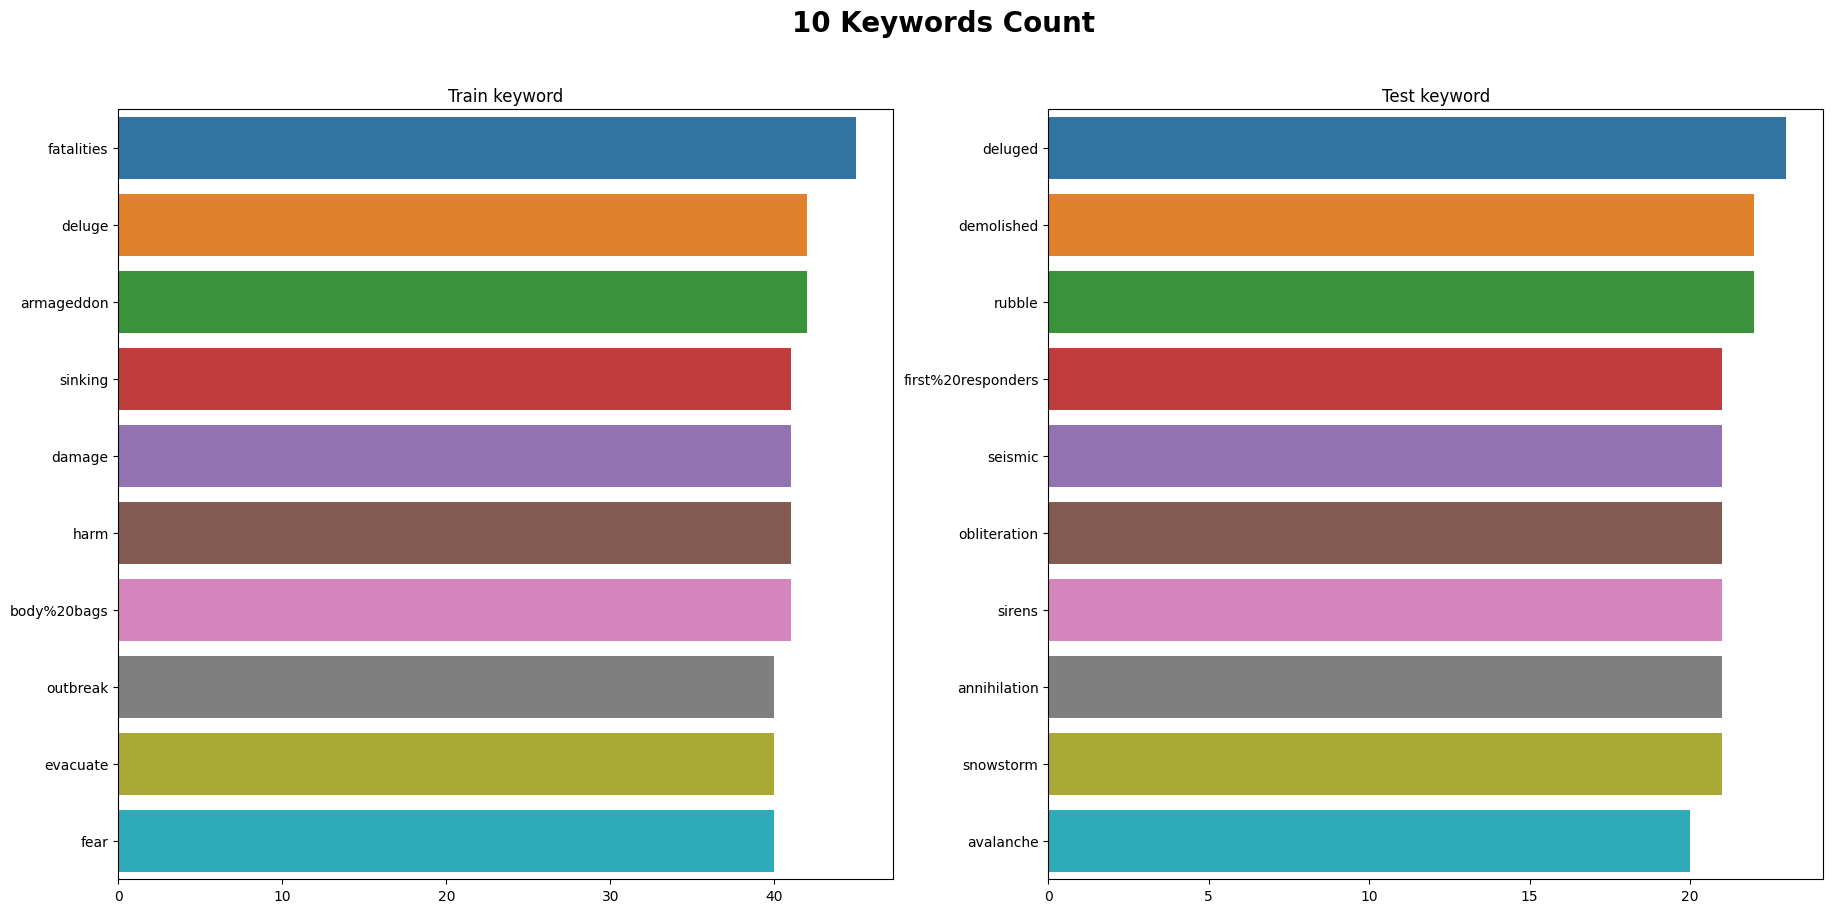

In [14]:
#@title different keywords
train_key = dict(train_data['keyword'].value_counts())
test_key = dict(test_data['keyword'].value_counts())
fig,axs  = plt.subplots(figsize  = (22,10))
fig.suptitle('10 Keywords Count', ha='center', fontweight='bold', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Train keyword')
sns.barplot(y=list(train_key.keys())[:10], x=list(train_key.values())[:10])

plt.subplot(1, 2, 2)
plt.title('Test keyword')
sns.barplot(y=list(test_key.keys())[:10], x=list(test_key.values())[:10])

/tmp/ipykernel_32/309339755.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,1)


([<matplotlib.patches.Wedge at 0x7cc57f802470>,
 [Text(-0.7595352245921734, 0.7956797362027747, 'Test'),
  Text(0.9666811949354928, -1.0126833006217135, 'Nulls')],
 [Text(-0.41429194068664, 0.434007128837877, '74.26%'),
  Text(0.6214379110299596, -0.6510106932568158, '25.74%')])

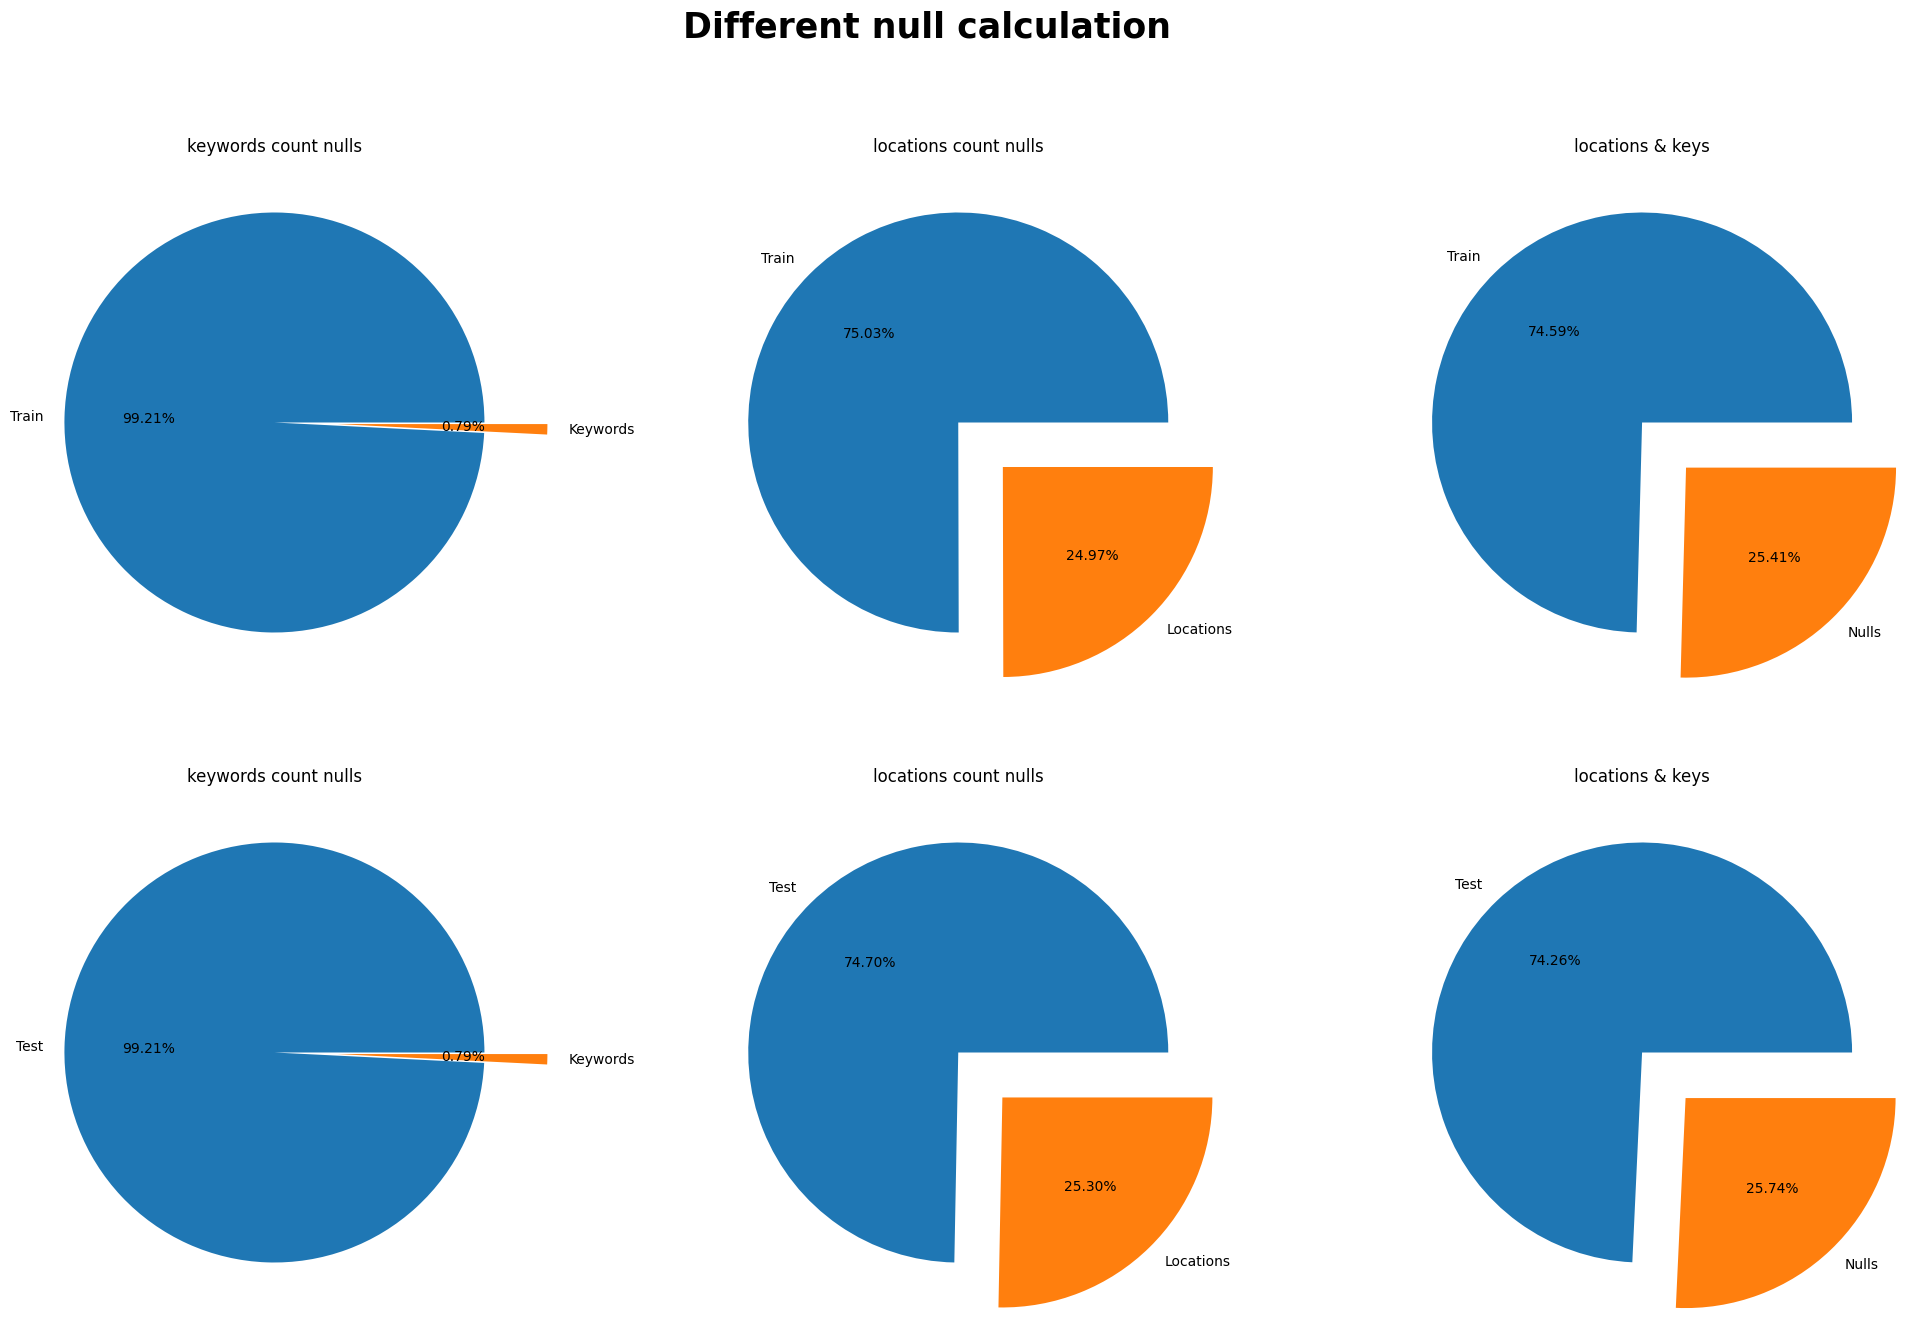

In [15]:
#@title count nulls
train_keywords_nulls = train_data['keyword'].isna().sum()
train_locations_nulls = train_data['location'].isna().sum()

test_keywords_nulls = test_data['keyword'].isna().sum()
test_locations_nulls = test_data['location'].isna().sum()

fig , axs = plt.subplots(figsize = (25,15))
fig.suptitle('Different null calculation' , ha = 'center' , fontsize = 25 , fontweight = 'bold')

# trian
plt.subplot(2,3,1)
plt.title('keywords count nulls')
plt.pie(x = [train_data.shape[0],train_keywords_nulls] , labels = ['Train' , 'Keywords'] , autopct = '%0.2f%%',explode = (0,0.3))

plt.subplot(2,3,2)
plt.title('locations count nulls')
plt.pie(x = [train_data.shape[0],train_locations_nulls] , labels = ['Train' , 'Locations'] , autopct = '%0.2f%%',explode = (0,0.3))

plt.subplot(2,3,3)
plt.title('locations & keys')
plt.pie(x = [train_data.shape[0],train_locations_nulls+train_keywords_nulls] , labels = ['Train' , 'Nulls'] , autopct = '%0.2f%%',explode = (0,0.3))

# test
plt.subplot(2,3,4)
plt.title('keywords count nulls')
plt.pie(x = [test_data.shape[0],test_keywords_nulls] , labels = ['Test' , 'Keywords'] , autopct = '%0.2f%%',explode = (0,0.3))

plt.subplot(2,3,5)
plt.title('locations count nulls')
plt.pie(x = [test_data.shape[0],test_locations_nulls] , labels = ['Test' , 'Locations'] , autopct = '%0.2f%%',explode = (0,0.3))

plt.subplot(2,3,6)
plt.title('locations & keys')
plt.pie(x = [test_data.shape[0],test_locations_nulls+test_keywords_nulls] , labels = ['Test' , 'Nulls'] , autopct = '%0.2f%%',explode = (0,0.3))


# Text processing

In [18]:
#@title dealing with location nulls
# location feature
# location in this dataset is not important beacouse we`re focusing in the text of the person and we dont care of his location
# so we can drop it
train_data.drop('location' , axis =1 , inplace = True)
test_data.drop('location' , axis =1 , inplace = True)


In [19]:
#@title dealing with keywords nulls
# keywords
# keywords is also un import beacuse we can extract the meaning of text
# another way you can keep it and training on it only
# so we now can handle it and training the text and keywords , see which is better

print(len(train_data[train_data['keyword'].isna()]['text']))
# beacuse the size of null of keywords is so small comparing to data , so we can handle this ourselfs

texts_keywords_null = train_data[train_data['keyword'].isna()]['text'].unique().tolist()

print(texts_keywords_null)
keywords = []

for text in texts_keywords_null:
  l_tmp = re.findall(r'#\w+',text)

  if len(l_tmp) > 1 : l_tmp = list(l_tmp[0])
  if len(l_tmp) > 0 :l_tmp = l_tmp[0][1:]
  if len(l_tmp) == 0: l_tmp = ' '.join(text.split(' ')[:3])
  keywords.append(''.join(l_tmp))

c = 0
for i in range(train_data.shape[0]):
  if train_data.loc[i,['keyword']].isna()[0]:
    train_data.loc[i,['keyword']] = keywords[c]
    c +=1

print(train_data['keyword'].isna().sum())


keywords = []
texts_keywords_null = test_data[test_data['keyword'].isna()]['text'].unique().tolist()

for text in texts_keywords_null:
  l_tmp = re.findall(r'#\w+',text)

  if len(l_tmp) > 1 : l_tmp = list(l_tmp[0])
  if len(l_tmp) > 0 :l_tmp = l_tmp[0][1:]
  elif len(l_tmp) == 0: l_tmp = ' '.join(text.split(' ')[:3])
  keywords.append(''.join(l_tmp))

c = 0
for i in range(test_data.shape[0]):
  if test_data.loc[i,['keyword']].isna()[0]:
    test_data.loc[i,['keyword']] = keywords[c]
    c +=1


61
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask. Canada', "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected", '13,000 people receive #wildfires evacuation orders in California ', 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ', '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires', '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas', "I'm on top of the hill and I can see a fire in the woods...", "There's an emergency evacuation happening now in the building across the street", "I'm afraid that the tornado is coming to our area...", 'Three people died from the heat wave so far', 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK 

In [20]:
#@title make pipline that correct syntax of tokens & Lemmatization
@Language.component('auto_correct')
def auto_correct(doc):
  spell = SpellChecker()
  corrected_text = []
  for token in doc:
       if spell.unknown([token.lemma_]):

            suggestions = spell.candidates(token.lemma_)


            if suggestions != None :
                corrected_word = list(suggestions)[0]
            else:

                corrected_word =  spell.correction(token.lemma_)
       else:

            corrected_word = token.lemma_


       if corrected_word is None: continue

       if corrected_word.startswith('@'):corrected_word = corrected_word[1:]
       elif corrected_word.startswith('@_'):corrected_word = corrected_word[2:]
       corrected_text.append(corrected_word)

  doc = nlp.make_doc(" ".join(corrected_text))
  return doc
nlp.add_pipe('auto_correct')
nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False},
  'auto_correct': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False}},
 'problems': {'tok2vec': [],


In [21]:
#@title stopwords
def text_proc(text):
  doc = nlp(text.lower())
  tokens = [token.text for token in doc ]

  garbage_chars  = [".",",",' ','(',')','"','\\','|','/','...',';',"'",'-','\r','\n','#',':-(',
                    '!','$','%','&','*','+','-',':',';','<','=','>','?','@','^','_','`','~','\n\n',
                    '....','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
                   'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  tokens = [token for token in tokens if not nlp.vocab[token].is_stop and token not in garbage_chars and not token.startswith('http')]
  if len(tokens) == 0: return doc.text
  return ' '.join(tokens)

In [ ]:
#@title apply text processing
train_data['text_proc'] = train_data['text'].apply(text_proc)
test_data['text_proc'] = test_data['text'].apply(text_proc)

In [ ]:
#@title smaple of data
train_data.head()

In [ ]:
test_data.head()

In [ ]:
#@title proc doc length
train_data['proc_doc_len'] = train_data['text_proc'].apply(lambda x : len(x))
test_data['proc_doc_len'] = test_data['text_proc'].apply(lambda x : len(x))
plt.title('Document length' )
sns.barplot(x = ['Train' , 'Test'] , y = [train_data['doc_len'].sum(), test_data['doc_len'].sum()], width = 0.3)

In [ ]:
train_data['text_proc'].iloc[19] = 'what a'
train_data['text_proc'].iloc[24] = 'so bad'# let this
train_data['text_proc'].iloc[113] = 'i dont like it' # let this
train_data['text_proc'].iloc[131] = 'bad'# t
train_data['text_proc'].iloc[428] = 'who maked this'
train_data['text_proc'].iloc[3922] = 'but he dont'
train_data['text_proc'].iloc[4297] ='then i do this to one of they'
train_data['text_proc'].iloc[4497] ='i dont have they out here'
train_data['text_proc'].iloc[4891] ='be you serious'
train_data['text_proc'].iloc[5115] = 'dont do this'
train_data['text_proc'].iloc[6766] = 'then do not'
test_data['text_proc'].iloc[11] = 'do not do that'
test_data['text_proc'].iloc[13]  = 'what if'
test_data['text_proc'].iloc[54] = 'so bad'
test_data['text_proc'].iloc[59] = 'i dont do that'
test_data['text_proc'].iloc[632]  ='call'

In [ ]:
#@title WordCloud visualize for proc text
def visualize_wordcloud(text, title):
    wordcloud = WordCloud(width= 1000, height=400, background_color='black').generate(text)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()


text_train = ' '.join(train_data['text_proc'].tolist())
text_test = ' '.join(test_data['text_proc'].tolist())
for i,text in enumerate([text_train, text_test]):
  visualize_wordcloud(text,['Train Data' ,'Test Data'][i])

text_disaster = ' '.join(train_data[train_data['target'] == 1]['text_proc'].tolist())
text_not_disaster = ' '.join(train_data[train_data['target'] == 0]['text_proc'].tolist())
for i,text in enumerate([text_not_disaster , text_disaster]):
  visualize_wordcloud(text,labels[i])

In [ ]:
#@title convert text to numerical
# tfidf
vectorizer1 = TfidfVectorizer()
def tfidf(documents):
  tfidf_vectors = vectorizer1.fit_transform(documents)
  tfidf_vectors = tfidf_vectors.toarray()
  return tfidf_vectors

# bow
vectorizer2 = CountVectorizer()
def bow(documents):
 bow_vectors = vectorizer2.fit_transform(documents)
 bow_vectors = bow_vectors.toarray()
 return bow_vectors

In [ ]:
# test
# tfidf
def tfidf_test(documents):
  tfidf_vectors = vectorizer1.transform(documents)
  tfidf_vectors = tfidf_vectors.toarray()
  return tfidf_vectors

# bow

def bow_test(documents):
 bow_vectors = vectorizer2.transform(documents)
 bow_vectors = bow_vectors.toarray()
 return bow_vectors

# Model

In [ ]:
#@title using tfidf
X = tfidf(train_data['text_proc'].tolist())

y = np.array(train_data['target'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_test = tfidf_test(test_data['text_proc'].tolist())


In [ ]:
print('Using TFIDF:\n')
kf = KFold(n_splits = 5 ,shuffle = True , random_state = 42)
best_score_rfr , best_score_xgb , best_score_nb = -1 , -1, -1
rfr = RandomForestClassifier(n_estimators = 250 ,max_depth = 15 ,random_state = 42)
xgb = XGBClassifier(learning_rate = 0.01 ,max_depth = 15 ,random_state = 42)
nb = MultinomialNB()
for fold ,(train_idx , val_idx) in enumerate(kf.split(X)):
  X_train , y_train  = X[train_idx] , y[train_idx]
  X_val , y_val = X[val_idx], y[val_idx]
  rfr.fit(X_train , y_train)
  xgb.fit(X_train , y_train)
  nb.fit(X_train , y_train)

  print(f'RandomForest{fold+1}')
  print(f'Train Score =  {rfr.score(X_train,y_train)}')
  print(f'Val Score = {rfr.score(X_val , y_val)}')
  y_pred = rfr.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,rfr.predict(X_val))}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_rfr = max(best_score_rfr ,f1_score(y_val,y_pred))

  print(f'Xgboost{fold+1}')
  print(f'Train Score =  {xgb.score(X_train,y_train)}')
  print(f'Val Score = {xgb.score(X_val , y_val)}')
  y_pred = xgb.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,y_pred)}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_xgb = max(best_score_xgb ,f1_score(y_val,y_pred))

  print(f'NB{fold+1}')
  print(f'Train Score =  {nb.score(X_train,y_train)}')
  print(f'Val Score = {nb.score(X_val , y_val)}')
  y_pred = nb.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,y_pred)}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_nb = max(best_score_nb ,f1_score(y_val,y_pred))

In [ ]:
print(f'RandomForestClassifier = {best_score_rfr} , Xgboost = {best_score_xgb} , NB = {best_score_nb}')

In [ ]:
sub_p = '/kaggle/input/nlp-getting-started/sample_submission.csv'
y_pred_tfidf = nb.predict(X_test)
output = pd.read_csv(sub_p)
output['target'] = y_pred_tfidf
output.to_csv('ouput_tfidf.csv' , index = False)
output.head()

In [ ]:
#@title using bow
X = bow(train_data['text_proc'].tolist())

y = np.array(train_data['target'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_test = bow_test(test_data['text_proc'].tolist())

In [ ]:
print('Using BOW:\n')
kf = KFold(n_splits = 5 ,shuffle = True , random_state = 42)
best_score_rfr , best_score_xgb , best_score_nb = -1 , -1, -1
rfr = RandomForestClassifier(n_estimators = 250 ,max_depth = 15 ,random_state = 42)
xgb = XGBClassifier(learning_rate = 0.01 ,max_depth = 15 ,random_state = 42)
nb = MultinomialNB()
for fold ,(train_idx , val_idx) in enumerate(kf.split(X)):
  X_train , y_train  = X[train_idx] , y[train_idx]
  X_val , y_val = X[val_idx], y[val_idx]
  rfr.fit(X_train , y_train)
  xgb.fit(X_train , y_train)
  nb.fit(X_train , y_train)

  print(f'RandomForest{fold+1}')
  print(f'Train Score =  {rfr.score(X_train,y_train)}')
  print(f'Val Score = {rfr.score(X_val , y_val)}')
  y_pred = rfr.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,rfr.predict(X_val))}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_rfr = max(best_score_rfr ,f1_score(y_val,y_pred))

  print(f'Xgboost{fold+1}')
  print(f'Train Score =  {xgb.score(X_train,y_train)}')
  print(f'Val Score = {xgb.score(X_val , y_val)}')
  y_pred = xgb.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,y_pred)}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_xgb = max(best_score_xgb ,f1_score(y_val,y_pred))

  print(f'NB{fold+1}')
  print(f'Train Score =  {nb.score(X_train,y_train)}')
  print(f'Val Score = {nb.score(X_val , y_val)}')
  y_pred = nb.predict(X_val)
  print(f'F1 score = {f1_score(y_val,y_pred)}')
  print(f'Loss = {log_loss(y_val,y_pred)}')
  print(f'Classification report :\n {classification_report (y_val,y_pred)}')
  print(f'Confusion Matrix :\n {ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_val ,y_pred),display_labels = labels).plot()}')
  best_score_nb = max(best_score_nb ,f1_score(y_val,y_pred))

In [ ]:
print(f'RandomForestClassifier = {best_score_rfr} , Xgboost = {best_score_xgb} , NB = {best_score_nb}')

In [ ]:
sub_p = '/kaggle/input/nlp-getting-started/sample_submission.csv'
y_pred_bow = rfr.predict(X_test)
output = pd.read_csv(sub_p)
output['target'] = y_pred_bow
output.to_csv('ouput_bow.csv' , index = False)
output.head()